### Sentiment analysis by scene

In [1]:
from __future__ import division

In [2]:
import os
import re
import nltk
import pandas as pd
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
afinn96 = pd.read_table('AFINN/AFINN-96.txt', names=['word','score'])
afinn111 = pd.read_table('AFINN/AFINN-111.txt', names=['word','score'])

In [5]:
afinn = afinn111.merge(afinn96[~afinn96.word.isin(afinn111.word.values)], how='outer')

In [6]:
def score_text(tokens):
    score = 0
    for w in tokens:
        if w in afinn['word'].values:
            score += int(afinn[afinn.word == w]['score'])
    return score

def avg_word_valence(tokens):
    n_afinn = len([w for w in tokens if w in afinn.word.values])
    return score_text(tokens)/n_afinn

In [7]:
files = [f for f in os.listdir('plays') if f.endswith('.txt')]

In [8]:
f = open('plays/midsummersnightsdream.txt', 'r')
raw = f.read()
text = ' '.join([re.sub('\t', ' ', l) for l in raw.splitlines() if l != ''])

In [9]:
tokenizer = RegexpTokenizer(r'\w+')

In [10]:
plays = {}
for filename in files:
    title = filename[:-4]
    with open('plays/{}'.format(filename), 'r') as f:
        raw = f.read()
        text = ' '.join([re.sub('\t', ' ', l) for l in raw.splitlines() if l != ''])
        plays[title] = {'scenes': {}, 'sentiment': {}, 'avg_word_valence': {}}
        i = 1
        for scene in re.split('SCENE [IVXCLM]+ ', text)[1:]:
            n = i
            tokens = tokenizer.tokenize(scene)
            names = [w.lower() for w in set(tokens) if w.isupper()]
            tokens = [w.lower() for w in tokens if w.lower() not in names]
            plays[title]['scenes'][n] = [w for w in tokens if w not in nltk.corpus.stopwords.words('english')]
            plays[title]['sentiment'][n] = score_text(plays[title]['scenes'][n])
            plays[title]['avg_word_valence'][n] = avg_word_valence(plays[title]['scenes'][n])
            i += 1
        

In [11]:
scenes = {}
scenes_sentiment = {}
scenes_awv = {}
i = 1
for scene in re.split('SCENE [IVXCLM]+ ', text)[1:]:
    key = i
    tokens = tokenizer.tokenize(scene)
    names = [w.lower() for w in set(tokens) if w.isupper()]
    tokens = [w.lower() for w in tokens if w.lower() not in names]
    scenes[key] = [w for w in tokens if w not in nltk.corpus.stopwords.words('english')]
    scenes_sentiment[key] = score_text(scenes[key])
    scenes_awv[key] = avg_word_valence(scenes[key])
    i += 1

In [12]:
tmp = pd.DataFrame.from_dict(scenes_sentiment, orient='index').reset_index()

In [13]:
tmp.columns = ['scene', 'score']

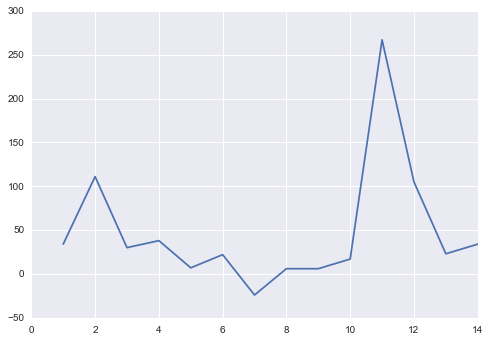

In [14]:
plt.plot(tmp.scene, tmp.score)

/Users/serena/.virtualenvs/shakespeare_analysis/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


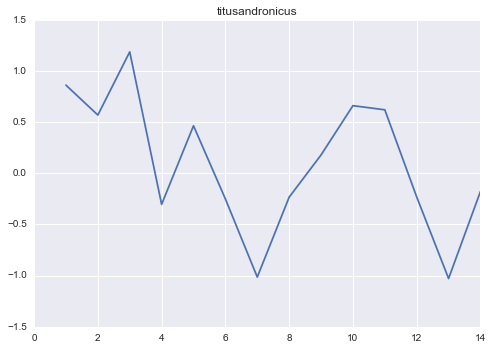

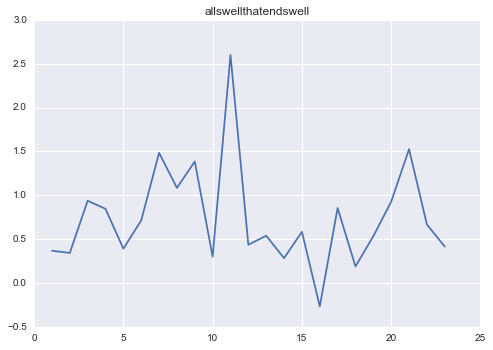

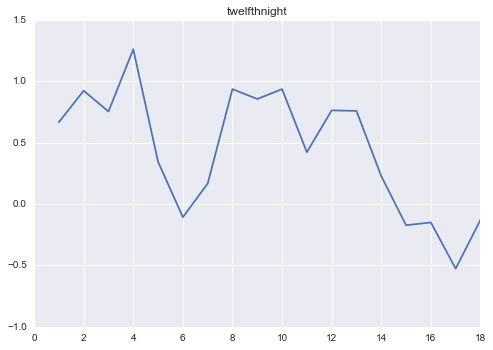

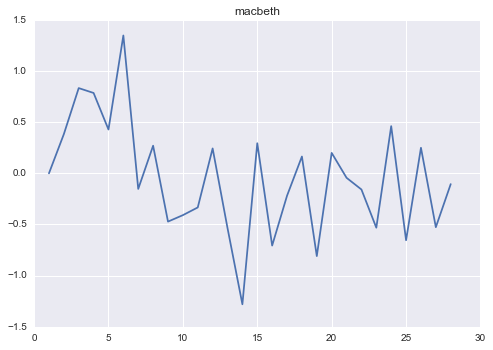

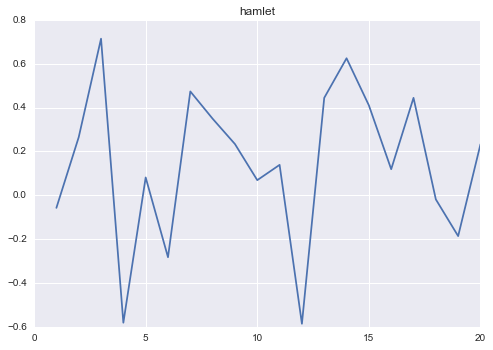

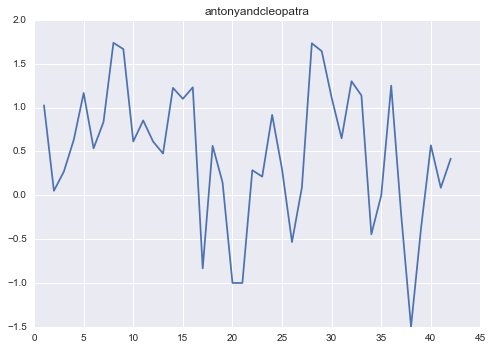

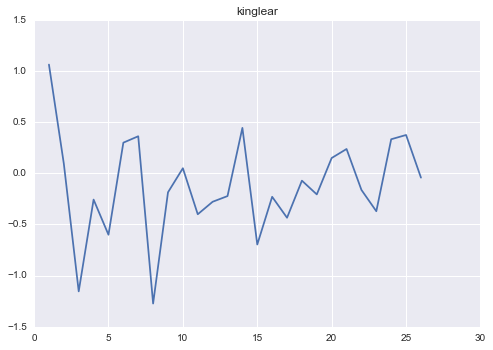

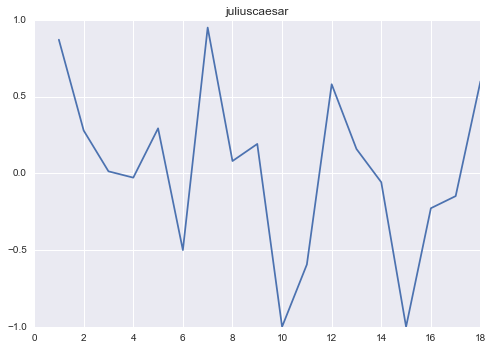

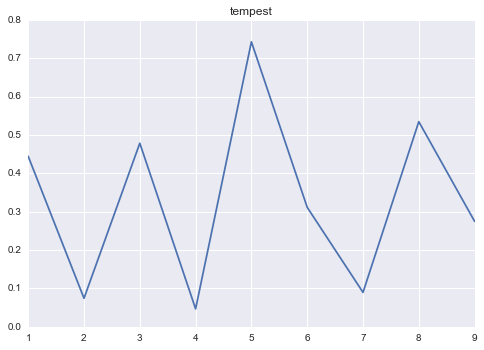

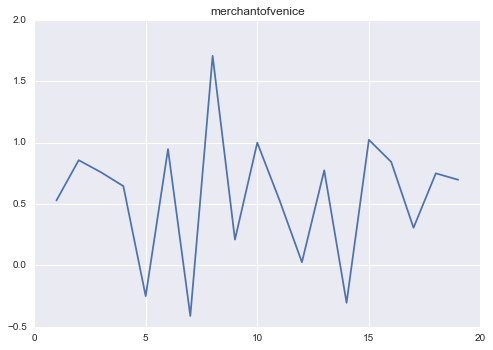

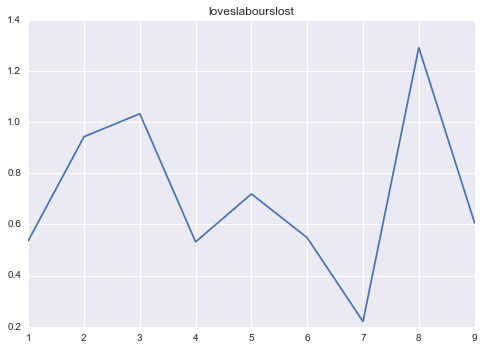

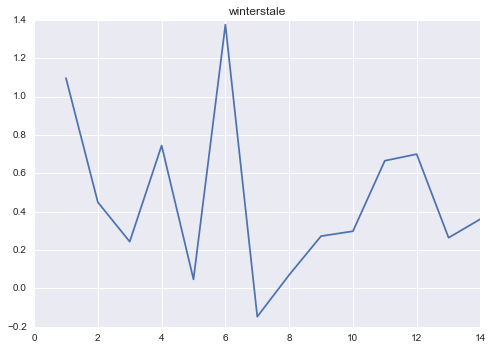

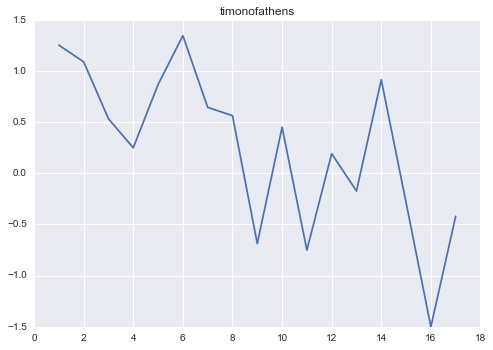

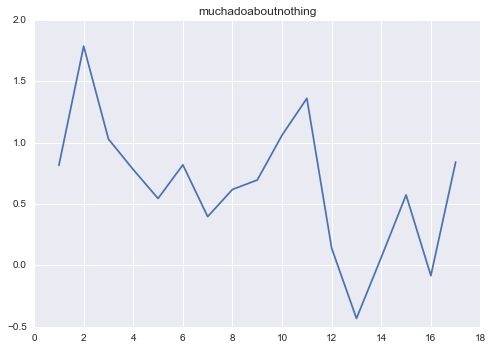

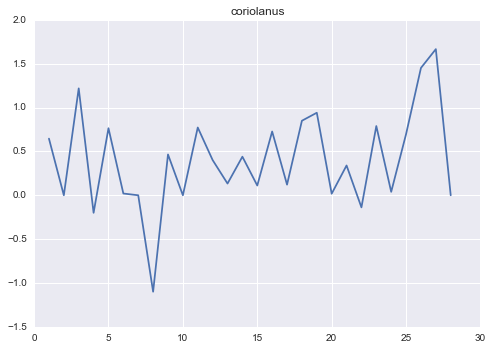

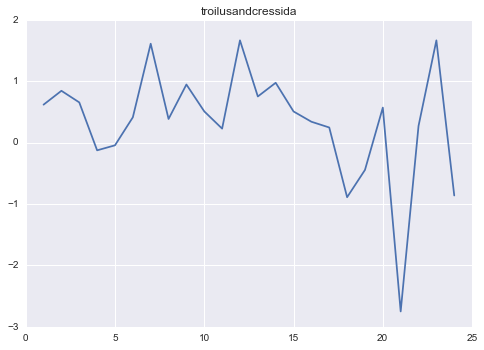

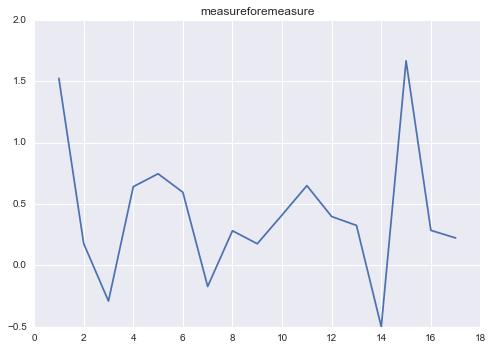

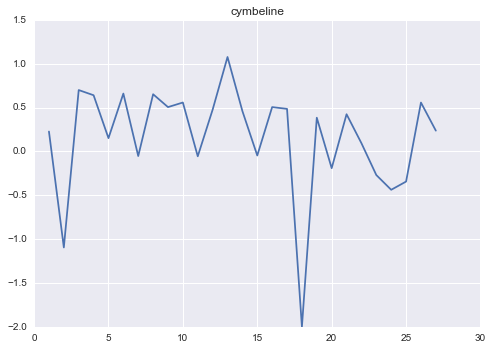

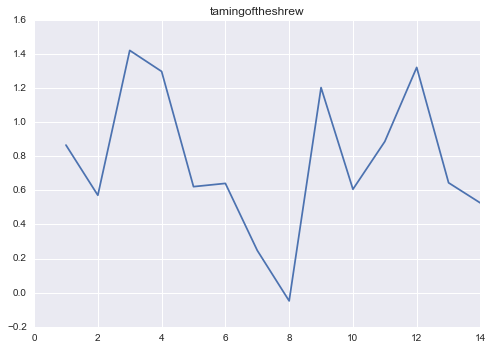

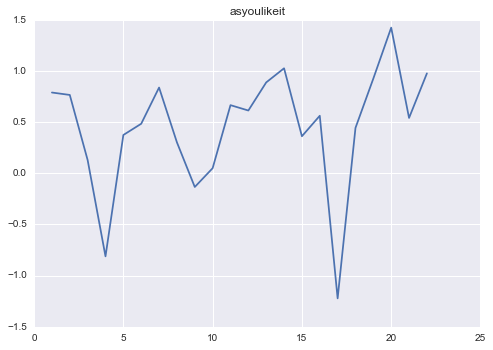

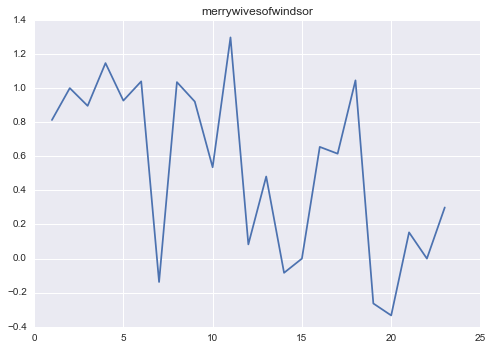

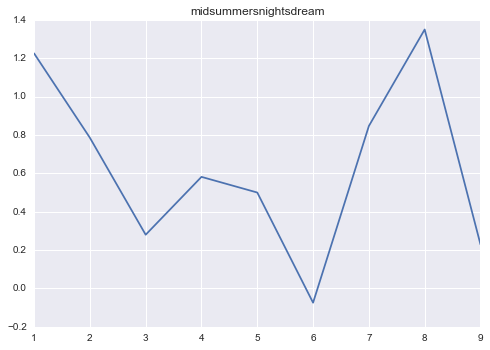

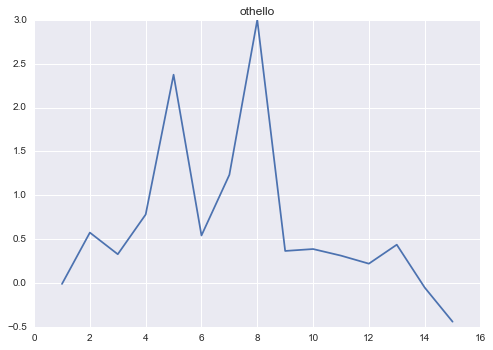

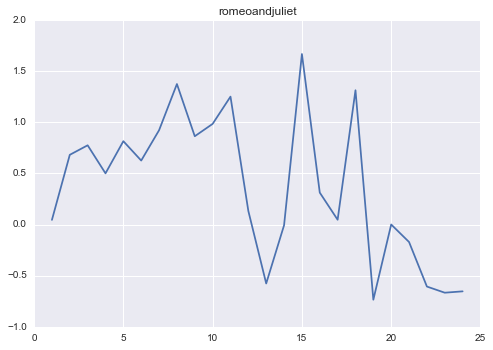

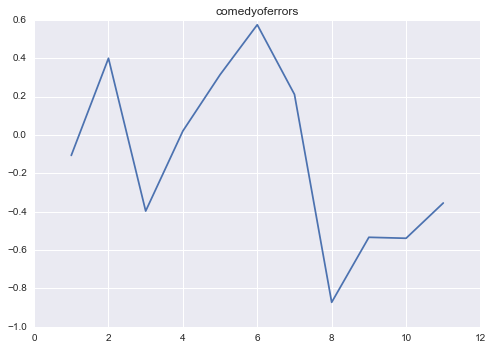

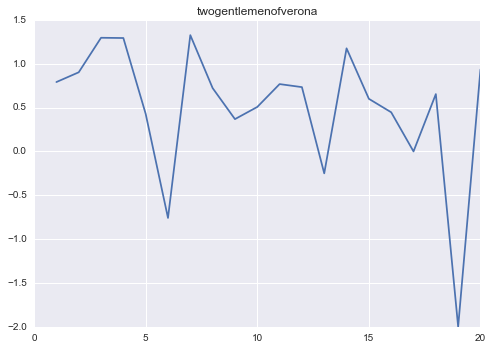

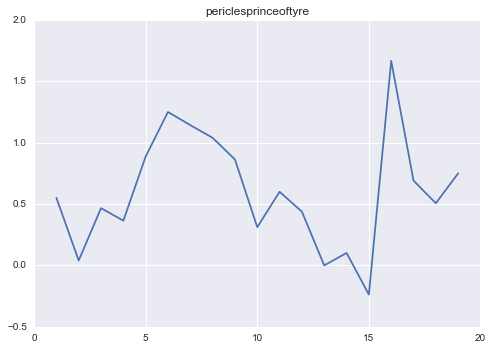

In [15]:
for title in plays.keys():
    tmp = pd.DataFrame.from_dict(plays[title]['avg_word_valence'], orient='index').reset_index()
    tmp.columns = ['scene', 'score']
    plt.figure()
    plt.plot(tmp.scene, tmp.score)
    plt.title(title)

In [16]:
def get_sentiment(plays, measure, title):
    return pd.DataFrame.from_dict(plays[title][measure], orient='index')

In [17]:

for title, scores in plays.items():
    sentimet_scores = get_sentiment(plays, 'avg_word_valence', title)
    s = pd.DataFrame({'title': title,
                  'min': sentimet_scores.min(),
                  'max': sentimet_scores.max(),
                  'mean': sentimet_scores.mean(),
                  'std': sentimet_scores.std()
                 })

In [18]:
lookup = pd.read_csv('outputs/lookup_titles.csv')

In [64]:
df = pd.DataFrame({'title': [title for title in plays.keys()],
                   'min': [float(get_sentiment(plays, 'avg_word_valence', title).min()) for title in plays.keys()],
                   'max': [float(get_sentiment(plays, 'avg_word_valence', title).max()) for title in plays.keys()],
                   'avg': [float(get_sentiment(plays, 'avg_word_valence', title).median()) for title in plays.keys()],
                   'st_dev': [float(get_sentiment(plays, 'avg_word_valence', title).std()) for title in plays.keys()]
                  })

In [65]:
df = df.merge(lookup[['title', 'label', 'year']], on='title')

In [66]:
from sklearn.cluster import KMeans

In [67]:
km = KMeans(n_clusters=2)

In [68]:
km.fit(df[['min', 'max', 'avg', 'st_dev']])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [69]:
df['cluster'] = km.labels_

In [70]:
df[km.labels_ == 1]['label'].value_counts()

comedy     12
tragedy     3
Name: label, dtype: int64

In [71]:
df[km.labels_ == 1]['year'].describe()

count      15.000000
mean     1600.133333
std         6.081197
min      1590.000000
25%      1595.500000
50%      1600.000000
75%      1604.000000
max      1610.000000
Name: year, dtype: float64

In [72]:
df[km.labels_ == 0]['label'].value_counts()

tragedy    7
comedy     5
Name: label, dtype: int64

In [73]:
df[km.labels_ == 0]['year'].describe()

count      12.000000
mean     1600.916667
std         6.748176
min      1589.000000
25%      1597.750000
50%      1602.500000
75%      1606.000000
max      1610.000000
Name: year, dtype: float64

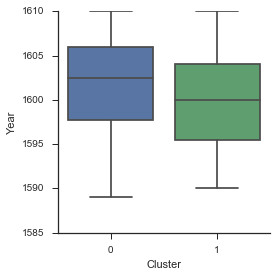

In [74]:
sns.set(style="ticks")

g = sns.factorplot(x = 'cluster', y = 'year', data = df, kind='box')
g.despine()
g.set_axis_labels('Cluster', 'Year')

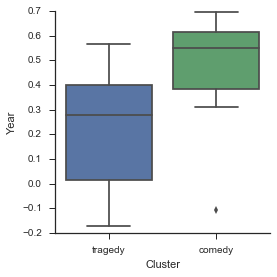

In [75]:
sns.set(style="ticks")

g = sns.factorplot(x = 'label', y = 'avg', data = df, kind='box')
g.despine()
g.set_axis_labels('Cluster', 'Year')